 # Import My Libraries 


In [57]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
from sklearn.cluster import MiniBatchKMeans


# Understanding the dataset

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in second
******************************************************
******************************************************

## Load dataset

In [2]:
train =pd.read_csv(r"C:\Users\lap shop\Desktop\machin\projects\1 project-nyc-taxi-trip-duration\split\train.csv")
val =pd.read_csv(r"C:\Users\lap shop\Desktop\machin\projects\1 project-nyc-taxi-trip-duration\split\val.csv")
RANDOM_STATE = 42


## Information about the dataset

In [3]:
train.shape

(1000000, 10)

In [4]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [5]:
# i do not need for id 
train.drop(columns="id",axis=1,inplace=True)
# in val 
#val.drop(columns='id',axis=1,inplace=True)

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1000000 non-null  int64  
 1   pickup_datetime     1000000 non-null  object 
 2   passenger_count     1000000 non-null  int64  
 3   pickup_longitude    1000000 non-null  float64
 4   pickup_latitude     1000000 non-null  float64
 5   dropoff_longitude   1000000 non-null  float64
 6   dropoff_latitude    1000000 non-null  float64
 7   store_and_fwd_flag  1000000 non-null  object 
 8   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 68.7+ MB


## Checking for missing values

In [8]:
train.isnull().sum().sum()

0

In [9]:
val.isnull().sum().sum()

0

## Datetime format

In [10]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
val['pickup_datetime'] = pd.to_datetime(val.pickup_datetime)


# target 

In [11]:
train['trip_duration'].describe()

count    1.000000e+06
mean     9.548850e+02
std      3.882070e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.074000e+03
max      2.227612e+06
Name: trip_duration, dtype: float64

- min is in 1s and max 25.78 day 
- so i will cleat it by  standard deviation from the mean.

In [12]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]
# only in train for genralzion 

Text(0.5, 1.0, 'trip_duration')

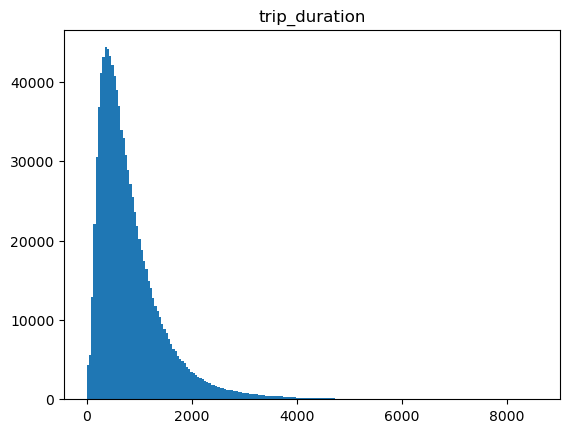

In [13]:
plt.hist(train['trip_duration'],bins=200)
plt.title("trip_duration")

- Right-Skewed Distribution:
- We need a log transformation for trip_duration

In [14]:
train["log_trip_duration"]=np.log(train['trip_duration'])
val["log_trip_duration"]=np.log(val['trip_duration'])

Text(0.5, 1.0, 'log_trip_duration')

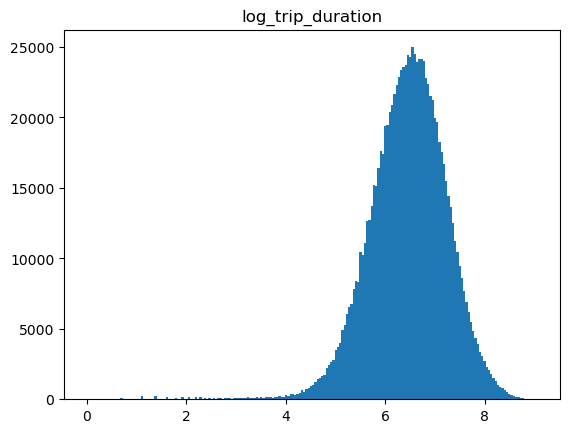

In [15]:
plt.hist(train['log_trip_duration'],bins=200)
plt.title("log_trip_duration")

## Numeric features

- numric is vendor_id ,pickup_longitude,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude 
- we need detect if found descrete feats and sperate it Because if they are included in numerical analysis , we won't find any correlation between discrete features and target feature.


In [16]:
discrete=[]
for col in train.columns:
    if train[col].dtype=='int64' and len(train[col].unique()) <=15:
        discrete.append(col)

In [17]:
print("Discrete Features :: \n\n{}".format(discrete))


Discrete Features :: 

['vendor_id', 'passenger_count']


### Visualize Discrete Features 

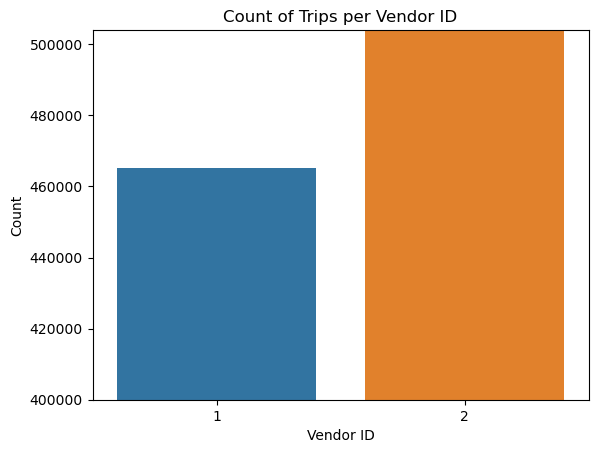

In [18]:
# vendor_id
sns.countplot(x=train['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.ylim(ymin=400000)
plt.ylim(ymax=504000)
plt.title('Count of Trips per Vendor ID')
plt.show()


In [19]:
# The difference between Vendor ID 1 and 2 is about 60,000

Text(0, 0.5, 'trip_duration')

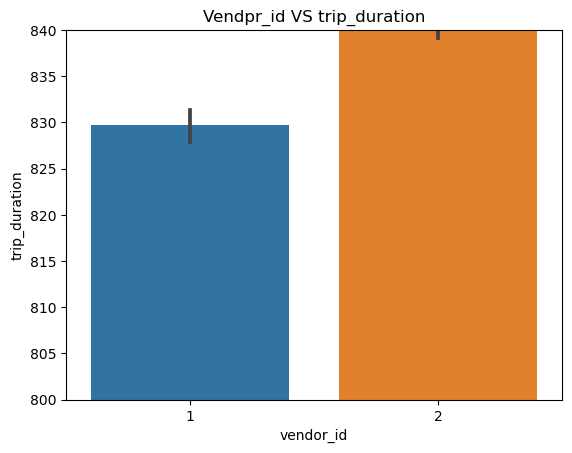

In [20]:
# vendor_id vs target 
sns.barplot(x=train['vendor_id'],y=train['trip_duration'])
plt.title('Vendpr_id VS trip_duration')
plt.ylim(ymin=800)
plt.ylim(ymax=840)
plt.xlabel('vendor_id')
plt.ylabel('trip_duration')

- The difference between the two vendors is 10, which is small

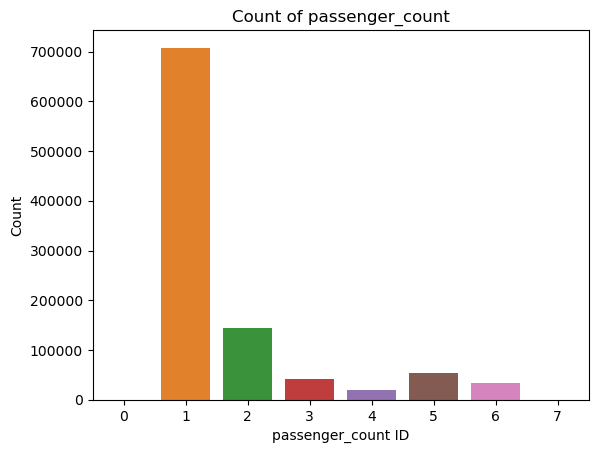

In [21]:
#passenger_count
sns.countplot(x=train['passenger_count'])
plt.xlabel('passenger_count ID')
plt.ylabel('Count')
plt.title('Count of passenger_count')
plt.show()


- The number of passenger counts for ID 1 is much higher than for the others
- The limit for the size of a taxi is no more than 6 passengers


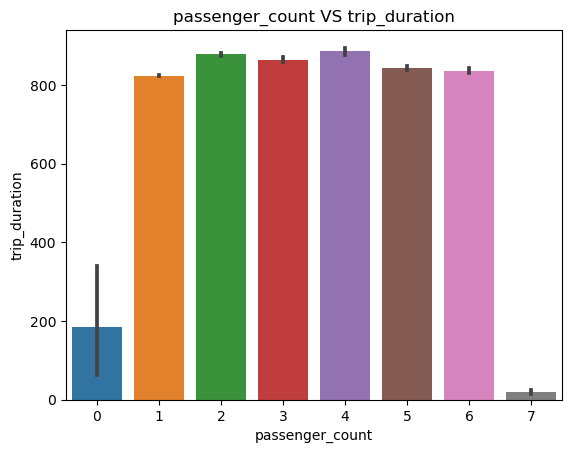

In [22]:
# passenger_count vs targe

sns.barplot(x=train['passenger_count'],y=train['trip_duration'])
plt.title('passenger_count VS trip_duration')

plt.xlabel('passenger_count')
plt.ylabel('trip_duration')
plt.show()

-  I found that the number of passengers, ranging from 1 to 6, is closely clustered and significantly impacts the target variabl 

### Visualize Continuous Features


"""Continuous Features  is'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
""" 

#### Latitude and Longitude Clean-up

- by searching  city_long_border = (-74.03, -73.75) city_lat_border = (40.63, 40.85)\
-  Comparing this to my data  we see that there are some coordinate points that outside New York, So we needs to clean that from the data. 




In [23]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

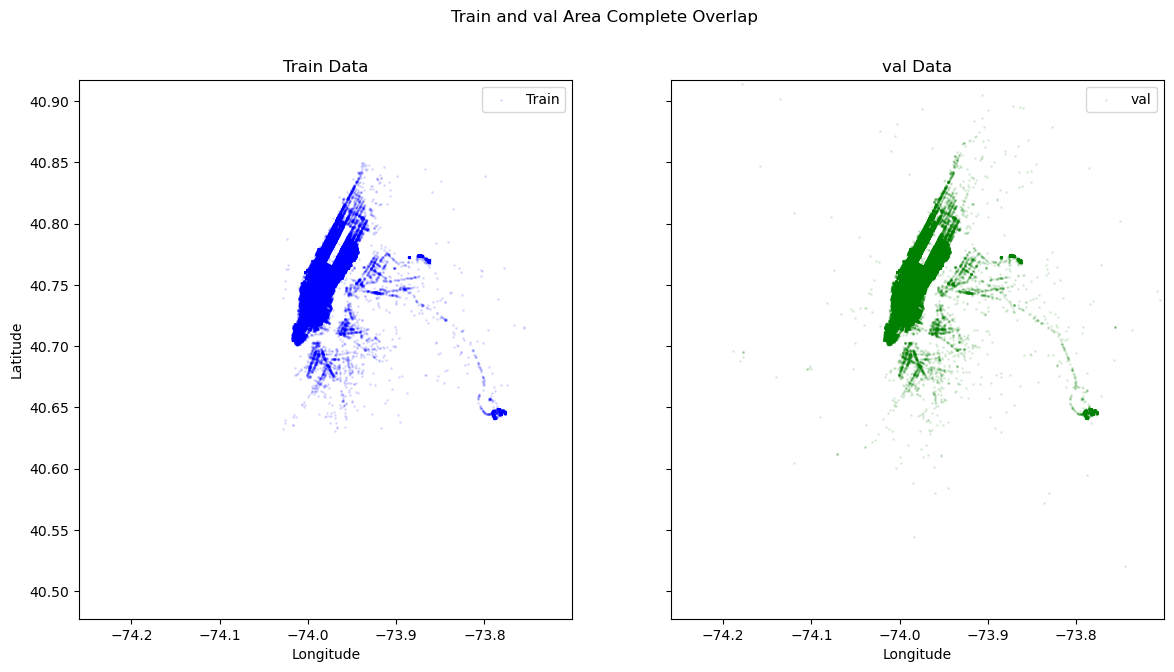

In [24]:


N = 100000  

# Define city borders for New York City (approximate values)
city_lat_border = [40.4774, 40.9176]  # Latitude borders for NYC
city_long_border = [-74.2591, -73.7004]  # Longitude borders for NYC

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 7))

# Plot for training data
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='Train', alpha=0.1)
ax[0].set_title('Train Data')
ax[0].legend(loc='best')
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')

# Plot for testing data
ax[1].scatter(val['pickup_longitude'].values[:N], val['pickup_latitude'].values[:N],
              color='green', s=1, label='val', alpha=0.1)
ax[1].set_title('val Data')
ax[1].legend(loc='best')
ax[1].set_xlabel('Longitude')

# Set limits to focus on the city area
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

fig.suptitle('Train and val Area Complete Overlap')
plt.show()

- In this case, the train and test split appears to be random. This allows us to use unsupervised learning and apply feature extraction to the full dataset.

## Datat Time 
- We just will change the format to be datetime rather than string to be applicable to work with it



In [25]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
val['pickup_datetime'] = pd.to_datetime(val.pickup_datetime)
train['pickup_date'] = train['pickup_datetime'].dt.date
val['pickup_date'] = val['pickup_datetime'].dt.date

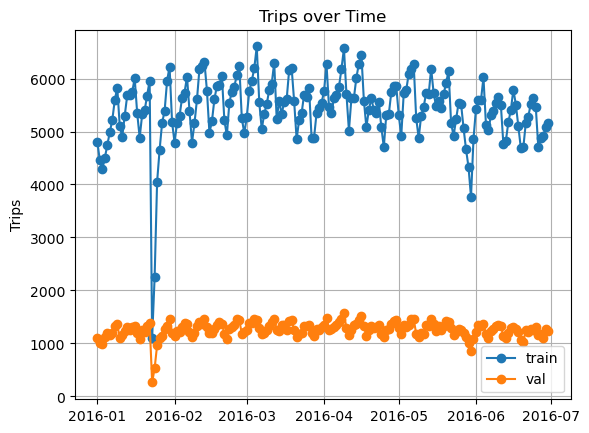

In [26]:
# Counting the number of trips for each date
train_counts = train.groupby('pickup_date').size()
val_counts = val.groupby('pickup_date').size()

plt.plot(train_counts.index, train_counts.values, 'o-', label='train')
plt.plot(val_counts.index, val_counts.values, 'o-', label='val')
plt.title('Trips over Time')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.grid()
plt.show()

 - It's clear that the two datasets is the same pattern but the val is more narrow 

# Extract New Features and visualization it 

## distance and direction 

In [27]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

haversine_array:
-  This function calculates the great-circle distance between two points on the Earth's surface given their latitude and - longitude coordinates using the Haversine formula.

dummy_manhattan_distance:
-  This function estimates the Manhattan distance (or taxicab distance) between two geographical points. In the context of taxi trip data, this can be an approximation of the actual driving distance in a grid-like city layout.

bearing_array:
- This function calculates the initial bearing (or forward azimuth) needed to get from a starting point to a destination point on the Earth's surface.


In [28]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'distance_haversine'] = haversine_array(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'direction'] = bearing_array(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)

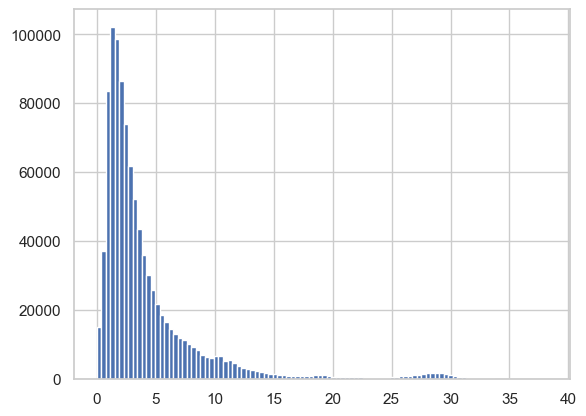

In [68]:
plt.hist(train['distance_dummy_manhattan'],bins=100)
plt.show()

 - is Right-Skewed Distribution:
- we need for  log transformation for distance_dummy_manhattan 

In [30]:
train["log_distance_dummy_manhattan"]=np.log1p(train['distance_dummy_manhattan'])
val["log_distance_dummy_manhattan"]=np.log1p(val['distance_dummy_manhattan'])

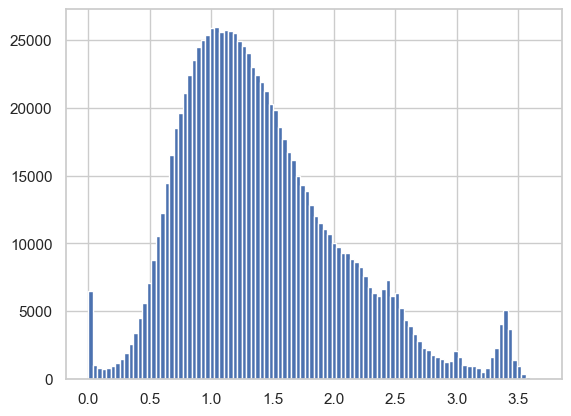

In [67]:
plt.hist(train['log_distance_dummy_manhattan'],bins=100)
plt.show()

In [32]:
train["log_distance_dummy_manhattan"].describe()

count    985141.000000
mean          1.407276
std           0.651039
min           0.000000
25%           0.940619
50%           1.295610
75%           1.767792
max           3.669610
Name: log_distance_dummy_manhattan, dtype: float64

- I have shown it is good.

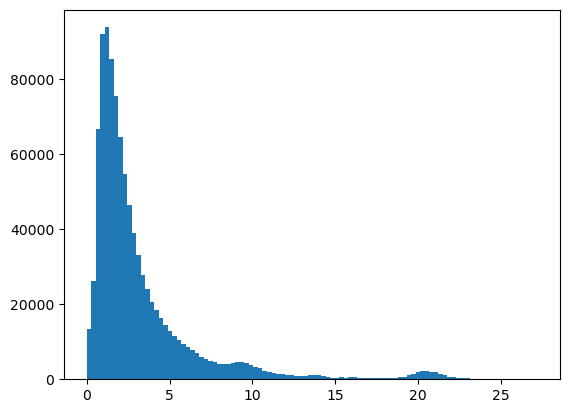

In [33]:
plt.hist(train['distance_haversine'],bins=100)
plt.show()

 -  is Right-Skewed Distribution:
-  we need for  log transformation for distance_haversine 

In [34]:
train["log_distance_haversine"]=np.log1p(train['distance_haversine'])
val["log_distance_haversine"]=np.log1p(val['distance_haversine'])


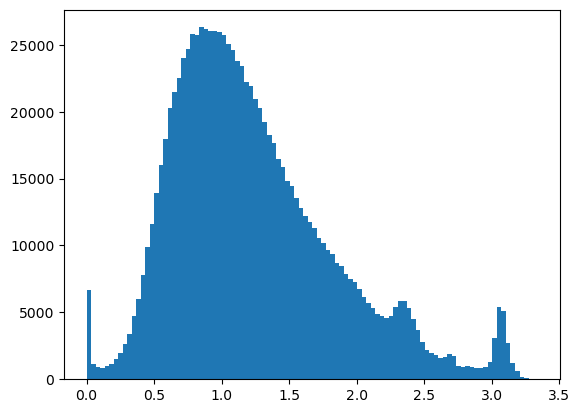

In [44]:
plt.hist(train['log_distance_haversine'],bins=100)
plt.show()

In [36]:
train["log_distance_haversine"].describe()

count    985141.000000
mean          1.236780
std           0.606991
min           0.000000
25%           0.799594
50%           1.120303
75%           1.560793
max           3.339025
Name: log_distance_haversine, dtype: float64

- I have shown it is good.

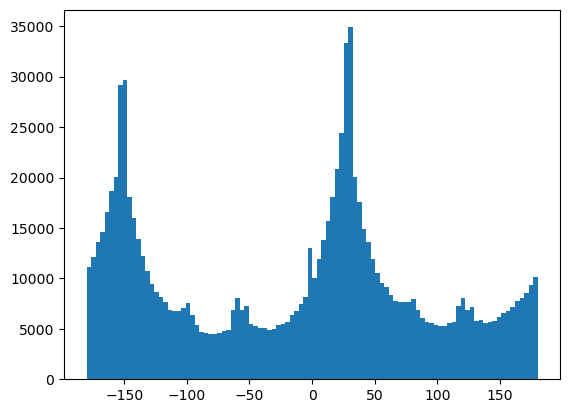

In [45]:
plt.hist(train['direction'],bins=100)
plt.show()

- The direction has noticeable peaks around -150, 0, and 150
- indicating these values are more frequent. The distribution is not uniform, suggesting some values are more prevalent than others

In [38]:
train['direction_sin'] = np.sin(np.radians(train['direction']))
train['direction_cos'] = np.cos(np.radians(train['direction']))
val['direction_sin'] = np.sin(np.radians(val['direction']))
val['direction_cos'] = np.cos(np.radians(val['direction']))


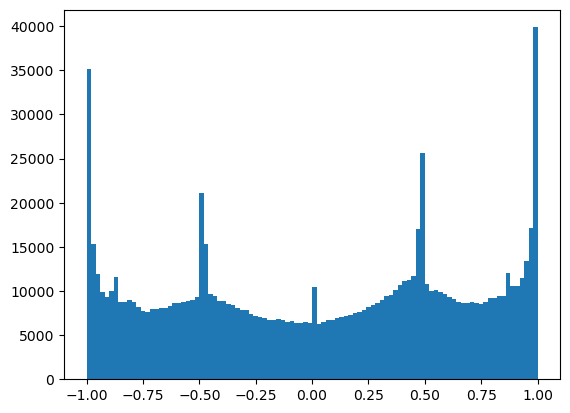

In [46]:
plt.hist(train['direction_sin'],bins=100)
plt.show()

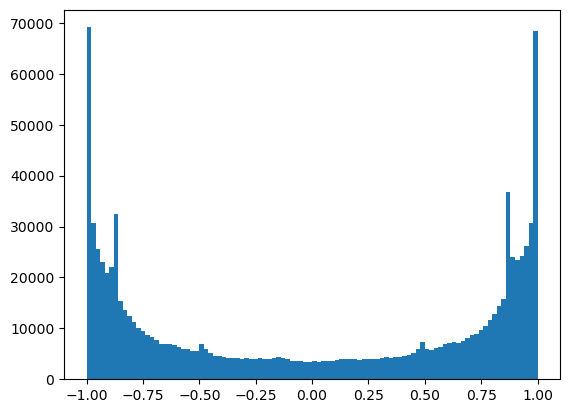

In [47]:
plt.hist(train['direction_cos'],bins=100)
plt.show()

### Now visualize vs target


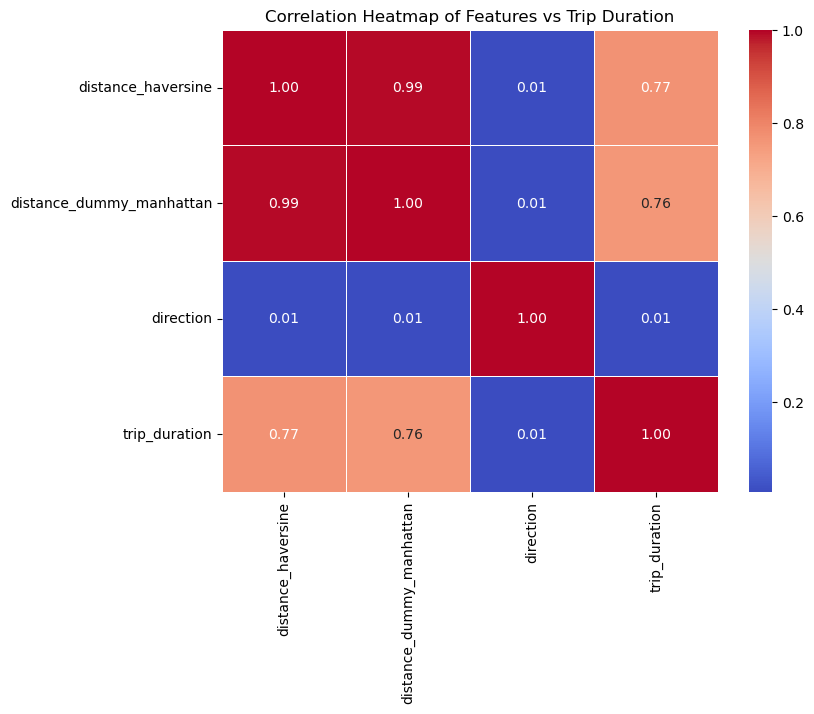

In [41]:
# Create a DataFrame containing the features and target
train_subset = train[['distance_haversine', 'distance_dummy_manhattan', 'direction', 'trip_duration']]

# Calculate the correlation matrix
corr_matrix = train_subset.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features vs Trip Duration')
plt.show()

 - The variables distance_haversine and distance_dummy_manhattan have a significant effect on the target

# Cluster Feature Extraction


In [58]:
def cluster_features(train, test, n_clusters=13, sample_size=500000, batch_size=10000, random_state=42):
    coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                        train[['dropoff_latitude', 'dropoff_longitude']].values))
    sample_ind = np.random.permutation(len(coords))[:sample_size]
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
    kmeans.fit(coords[sample_ind])
    train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
    train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
    test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
    test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
    return train, test, kmeans

In [59]:
train, val, kmeans_model = cluster_features(train, val, n_clusters=13)


C:\Users\lap shop\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\lap shop\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\lap shop\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\lap shop\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\lap shop\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


 pickup_cluster: 
 - A categorical feature representing the cluster assignment for the pickup location of each trip.
 - This is determined using MiniBatchKMeans clustering algorithm, which groups pickup latitude and longitude coordinates into 13   clusters.
 - Each cluster corresponds to a specific region or zone based on the geographical proximity of the pickup locations.

 dropoff_cluster: 
 - A categorical feature representing the cluster assignment for the dropoff location of each trip.
 - This is determined using MiniBatchKMeans clustering algorithm, which groups dropoff latitude and longitude coordinates into 13 clusters.
 - Each cluster corresponds to a specific region or zone based on the geographical proximity of the dropoff locations.


In [60]:
train["pickup_cluster"].describe()

count    985141.000000
mean          4.968037
std           3.700244
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          12.000000
Name: pickup_cluster, dtype: float64

In [61]:
train['pickup_cluster'].unique()

array([ 7,  3,  0,  1,  5,  4, 12,  9,  8,  6,  2, 10, 11])

- Is discrete.

In [62]:
train['dropoff_cluster'].describe()


count    985141.000000
mean          5.093556
std           3.656807
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          12.000000
Name: dropoff_cluster, dtype: float64

In [63]:
train['dropoff_cluster'].unique()

array([ 3,  0,  5,  9,  4,  7,  1, 11,  2, 12,  6, 10,  8])

- Is discrete.

### Now visualize vs Target


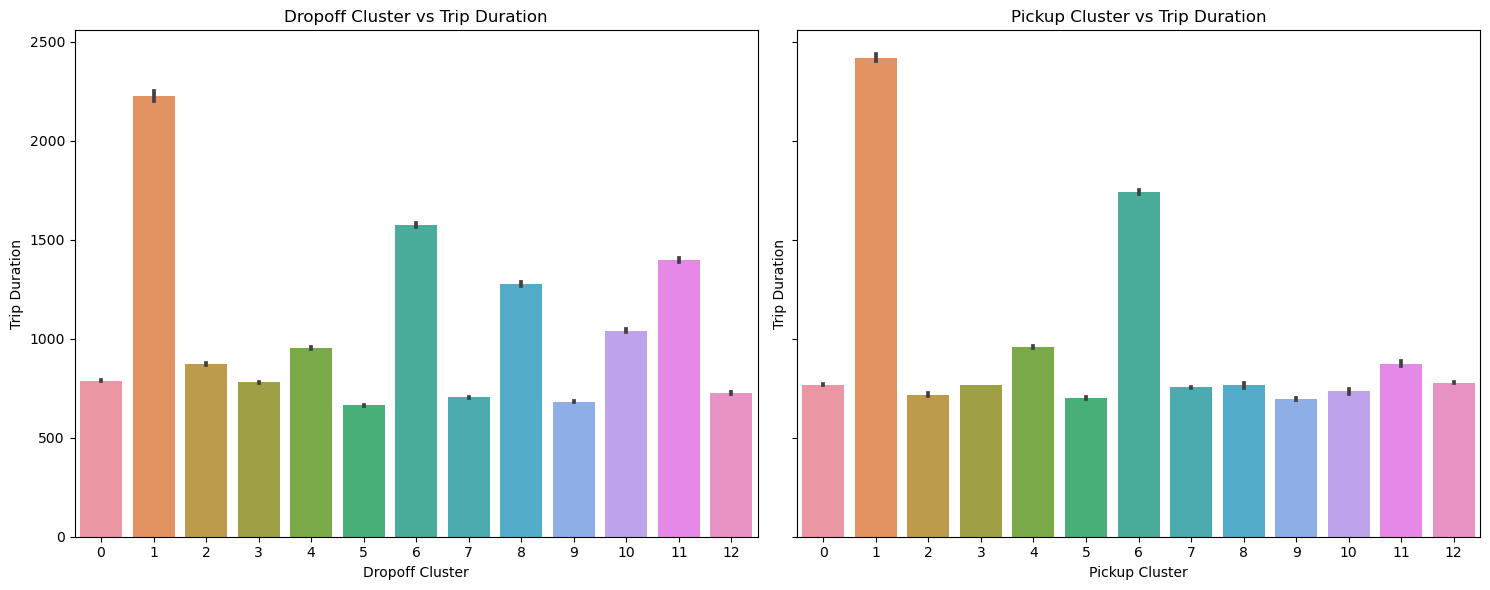

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for dropoff_cluster vs trip_duration
sns.barplot(x=train['dropoff_cluster'], y=train['trip_duration'], ax=axes[0])
axes[0].set_title('Dropoff Cluster vs Trip Duration')
axes[0].set_xlabel('Dropoff Cluster')
axes[0].set_ylabel('Trip Duration')

# Plot for pickup_cluster vs trip_duration
sns.barplot(x=train['pickup_cluster'], y=train['trip_duration'], ax=axes[1])
axes[1].set_title('Pickup Cluster vs Trip Duration')
axes[1].set_xlabel('Pickup Cluster')
axes[1].set_ylabel('Trip Duration')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


High Trip Durations:
- Both dropoff and pickup clusters have one cluster (Cluster 1) with exceptionally high trip durations, suggesting that trips starting or ending in these clusters are significantly longer.

Variability: 
- There is a noticeable variability in trip durations across different clusters, indicating that the location clusters play a significant role in trip duration


# Time Extraction


In [65]:
train['month']=train['pickup_datetime'].dt.month
val['month']=val['pickup_datetime'].dt.month

train['DayofMonth']=train['pickup_datetime'].dt.day
val['DayofMonth']=val['pickup_datetime'].dt.day

train['Hour']=train['pickup_datetime'].dt.hour
val['Hour']=val['pickup_datetime'].dt.hour

train['dayofweek']=train['pickup_datetime'].dt.dayofweek
val['dayofweek']=val['pickup_datetime'].dt.dayofweek

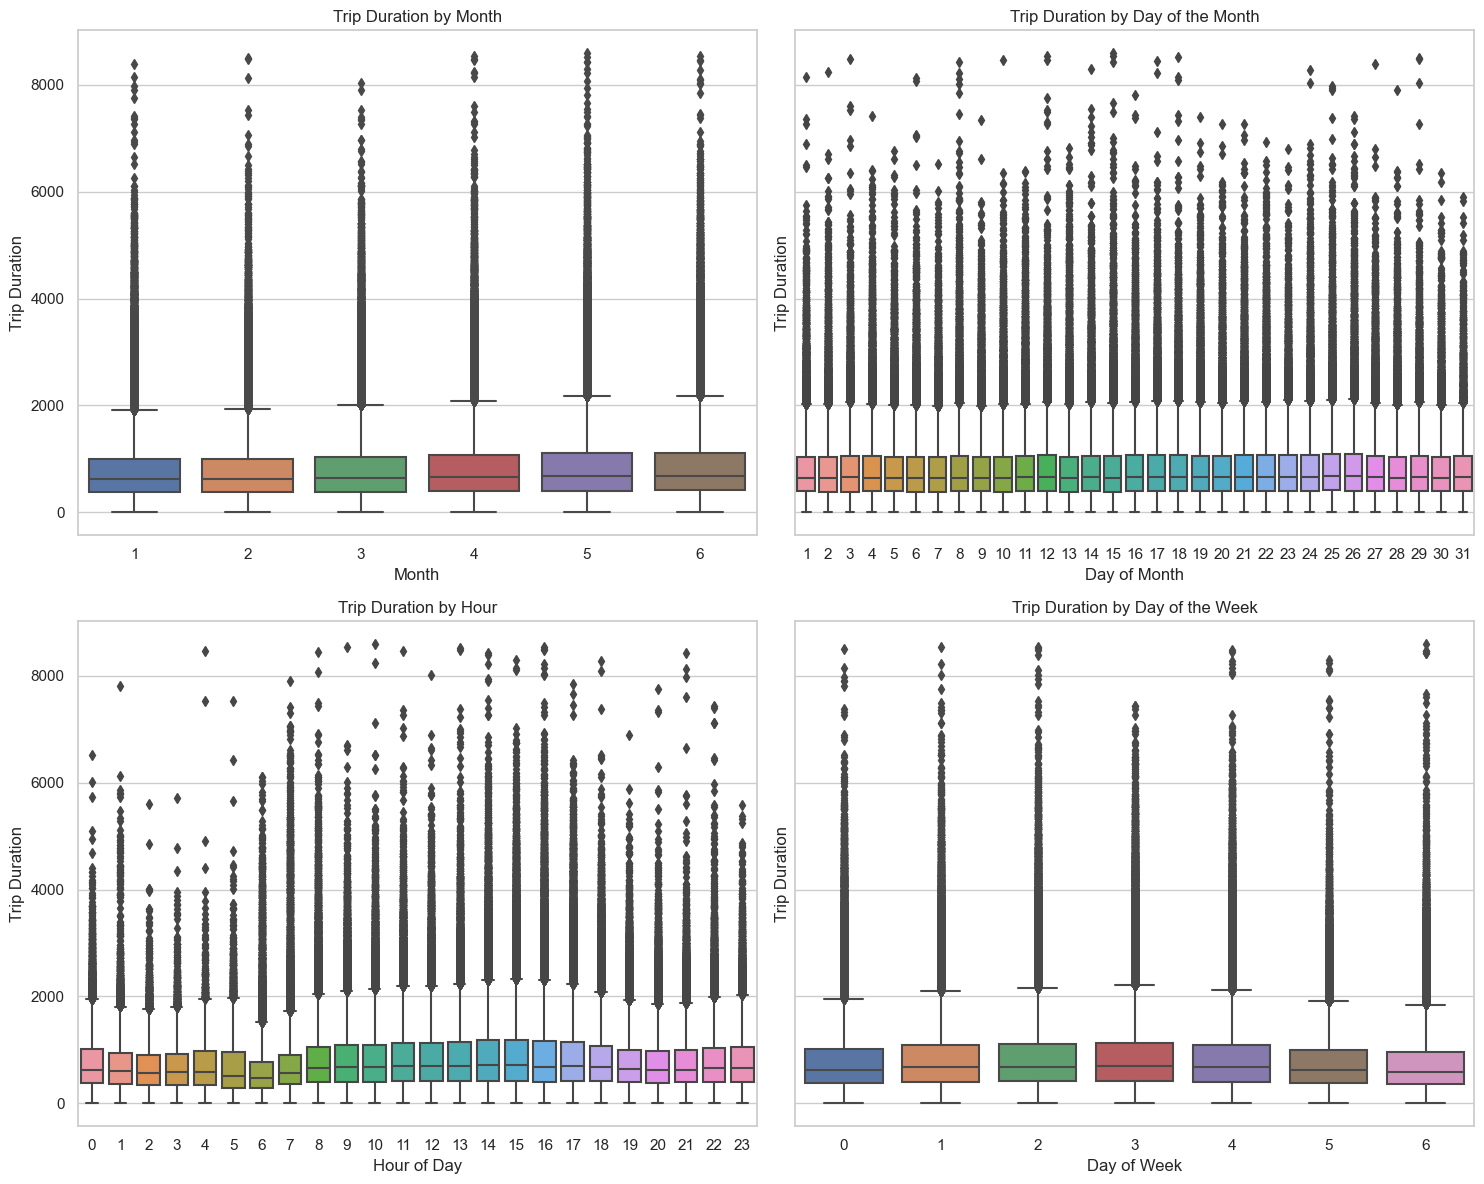

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)

# Plot for trip_duration by month
sns.boxplot(x='month', y='trip_duration', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Trip Duration by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Trip Duration')

# Plot for trip_duration by Day of the Month
sns.boxplot(x='DayofMonth', y='trip_duration', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Trip Duration by Day of the Month')
axes[0, 1].set_xlabel('Day of Month')
axes[0, 1].set_ylabel('Trip Duration')

# Plot for trip_duration by Hour
sns.boxplot(x='Hour', y='trip_duration', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Trip Duration by Hour')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Trip Duration')

# Plot for trip_duration by Day of the Week
sns.boxplot(x='dayofweek', y='trip_duration', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Trip Duration by Day of the Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Trip Duration')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Now, let's work on the  model
- EDA is finished

- Now, let's continue in pycharm to do model

